In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from difflib import SequenceMatcher
import pickle

In [2]:
property_dict = {
    "A": ["NonPolar", 'Neutral', 'Hydrophobic', 'NonAromatic', 'NonIonizable'],
    "R": ["Polar", "Positive", 'Hydrophilic', 'NonAromatic', 'Ionizable'],
    "N": ["Polar", 'Neutral', 'Hydrophilic', 'NonAromatic', 'NonIonizable'],
    "D": ["Polar", "Negative", 'Hydrophilic', 'NonAromatic', 'Ionizable'],
    "C": ["Polar", 'Neutral', 'Hydrophilic', 'NonAromatic', 'Ionizable'],
    "Q": ["Polar", 'Neutral', 'Hydrophilic', 'NonAromatic', 'NonIonizable'],
    "E": ["Polar", "Negative", 'Hydrophilic', 'NonAromatic', 'Ionizable'],
    "G": ["NonPolar", 'Neutral', 'Hydrophobic', 'NonAromatic', 'NonIonizable'],
    "H": ["Polar", "Positive", 'Hydrophilic', 'NonAromatic', 'Ionizable'],
    "I": ["NonPolar", 'Neutral', 'Hydrophobic', 'NonAromatic', 'NonIonizable'],
    "L": ["NonPolar", 'Neutral', 'Hydrophobic', 'NonAromatic', 'NonIonizable'],
    "K": ["Polar", "Positive", 'Hydrophilic', 'NonAromatic', 'Ionizable'],
    "M": ["NonPolar", 'Neutral', 'Hydrophobic', 'NonAromatic', 'NonIonizable'],
    "F": ["NonPolar", 'Neutral', 'Hydrophobic', "Aromatic", 'NonIonizable'],
    "P": ["NonPolar", 'Neutral', 'Hydrophobic', 'NonAromatic', 'NonIonizable'],
    "S": ["Polar", 'Neutral', 'Hydrophilic', 'NonAromatic', 'NonIonizable'],
    "T": ["Polar", 'Neutral', 'Hydrophilic', 'NonAromatic', 'NonIonizable'],
    "W": ["NonPolar", 'Neutral', 'Hydrophobic', "Aromatic", 'NonIonizable'],
    "Y": ["Polar", 'Neutral', 'Hydrophobic', "Aromatic", 'Ionizable'],
    "V": ["NonPolar", 'Neutral', 'Hydrophobic', 'NonAromatic', 'NonIonizable']
}

mapping = {'Hydrophobic':0, 'Hydrophilic':1, 'Neutral':0, 'Positive':1, 'Negative':-1, 'Polar':1, 'NonPolar':0, 'Aromatic':1, 'NonAromatic':0, 'Ionizable':1, 'NonIonizable':0}

feature_dict = {}
for key in property_dict.keys():
    vals = [mapping[p] for p in property_dict[key]]
    feature_dict[key.lower()] = vals

In [3]:
feature_dict

{'a': [0, 0, 0, 0, 0],
 'r': [1, 1, 1, 0, 1],
 'n': [1, 0, 1, 0, 0],
 'd': [1, -1, 1, 0, 1],
 'c': [1, 0, 1, 0, 1],
 'q': [1, 0, 1, 0, 0],
 'e': [1, -1, 1, 0, 1],
 'g': [0, 0, 0, 0, 0],
 'h': [1, 1, 1, 0, 1],
 'i': [0, 0, 0, 0, 0],
 'l': [0, 0, 0, 0, 0],
 'k': [1, 1, 1, 0, 1],
 'm': [0, 0, 0, 0, 0],
 'f': [0, 0, 0, 1, 0],
 'p': [0, 0, 0, 0, 0],
 's': [1, 0, 1, 0, 0],
 't': [1, 0, 1, 0, 0],
 'w': [0, 0, 0, 1, 0],
 'y': [1, 0, 0, 1, 1],
 'v': [0, 0, 0, 0, 0]}

### Load new features

In [4]:
feats = pd.read_csv("data/features_AA.csv", header=None)

In [5]:
feats = feats.replace(to_replace='-', value=0)

In [6]:
feats

,0,1,2,3,4,5,6,7,8,9
0,Alanine,Ala,A,89.10,71.08,2.34,9.69,0.00,6.00,47
1,Arginine,Arg,R,174.20,156.19,2.17,9.04,12.48,10.76,-26
2,Asparagine,Asn,N,132.12,114.11,2.02,8.80,0.00,5.41,-41
3,Aspartic acid,Asp,D,133.11,115.09,1.88,9.60,3.65,2.77,-18
4,Cysteine,Cys,C,121.16,103.15,1.96,10.28,8.18,5.07,52
5,Glutamic acid,Glu,E,147.13,129.12,2.19,9.67,4.25,3.22,8
6,Glutamine,Gln,Q,146.15,128.13,2.17,9.13,0.00,5.65,-18
7,Glycine,Gly,G,75.07,57.05,2.34,9.60,0.00,5.97,0
8,Histidine,His,H,155.16,137.14,1.82,9.17,6.00,7.59,-42
9,Hydroxyproline,Hyp,O,131.13,113.11,1.82,9.65,0.00,0.00,0


In [7]:
for i, row in feats.iterrows():
    l = list(row[3:])
    one_hot = [0 for _ in range(len(feats))]
    one_hot[i] = 1
    try:
        feature_dict[row[2].lower()].extend(l+one_hot)
    except KeyError:
        feature_dict[row[2].lower()] = [0 for _ in range(5)] + l + one_hot

In [8]:
prop_arr = np.array(list(feature_dict.values()))

In [9]:
mean_props = np.mean(prop_arr, axis=0)

In [10]:
feature_dict["x"] = mean_props # can be any
feature_dict["z"] = feature_dict["e"] # = e
feature_dict["b"] = list(0.5* (np.array(feature_dict["n"]) + np.array(feature_dict["d"]))) # mix of ([1, 0, 1, 0, 0], [1, -1, 1, 0, 1]) # n or d
feature_dict["j"] = list(0.5* (np.array(feature_dict["l"]) + np.array(feature_dict["i"]))) # [0,0,0,0,0] # =l = i

### Prepare data

In [11]:
def seq2features(seq):
    return [feature_dict[s.lower()] for s in seq]

def pad_seq_simple(seq, pad_len=10):
    return "".join(["x" for _ in range(pad_len)])+seq+"".join(["x" for _ in range(pad_len)])

def seq2windowfeatures(seq, window_r=4):
    seq_padded = pad_seq_simple(seq, pad_len=window_r)
    feats = np.array([feature_dict[s.lower()] for s in seq_padded])
    window_feats = np.array([feats[i-window_r:i+window_r+1] for i in range(window_r, len(seq)+window_r)])
    return window_feats

In [12]:
with open(os.path.join("data/raw/iedb_linear_epitopes.fasta"), "r") as infile:
    txt_linear = infile.read()

### Data for sequence model

In [38]:
linear = txt_linear.split(">")[1:]

linear_data_seq = list()
linear_labels = list()
linear_inds = list()

for i, entry in enumerate(linear[10000:10200]): # linear[:len(linear)//5] TRAIN DATA # 1000-1200 is TEST SET
    split_entry = entry.split("\n")
    
    linear_metadata.append(split_entry[0])
    
    # data for predictive model
    # only_epis = [s for s in split_entry[1] if s.isupper()]
    # linear_data_pred.append(seq2features(only_epis)) # simply features for each entry

    if split_entry[0][:3]=="Pos":
        linear_pos_neg.append(1)
        
        # data for the seq model: requires whole seq single with features
        gt = np.array([s.isupper() for s in split_entry[1]])
        inds = np.where(gt==1)[0]
        low = max([inds[0] - len(inds), 0])
        high = min([inds[-1] + len(inds), len(split_entry[1])])
        # print(inds, low, high)
        feat_arr = seq2windowfeatures(split_entry[1])
        linear_labels.append(gt[low:high])
        linear_data_seq.append(feat_arr[low:high])
        linear_inds.append([i for _ in range(len(split_entry[1]))])
        
    # if negative
    else: 
        linear_pos_neg.append(0)

In [39]:
linear_data_concat = np.concatenate(linear_data_seq, axis=0)
print(linear_data_concat.shape)

(138107, 9, 34)


In [40]:
linear_labels_concat = np.concatenate(linear_labels, axis=0)
linear_inds_concat = np.concatenate(linear_inds, axis=0)

In [44]:
138107 / 200 # average sequence length

690.535

In [45]:
with open("seq_model_test", "wb") as outfile:
    pickle.dump((linear_data_concat, linear_labels_concat, linear_inds_concat), outfile)

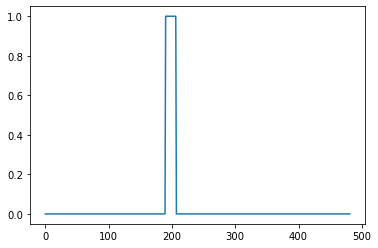

In [51]:
plt.plot(linear_labels[1])

### Data for predictive model

In [134]:
linear = txt_linear.split(">")[1:]

linear_data_pred = list()
linear_pos_neg = list()
for i, entry in enumerate(linear[:len(linear)//5]): # TRAIN DATA: 
    split_entry = entry.split("\n")
    
    # data for predictive model
    only_epis = [s for s in split_entry[1] if s.isupper()]
    linear_data_pred.append(seq2features(only_epis)) # simply features for each entry

    if split_entry[0][:3]=="Pos":
        linear_pos_neg.append(1)
    # if negative
    else: 
        linear_pos_neg.append(0)

# save
with open("pred_model_data", "wb") as outfile:
    pickle.dump((linear_data_pred, linear_pos_neg), outfile)

In [128]:
np.array(linear_data_pred[1]).shape

(433, 34)

In [131]:
linear[1]

'PositiveID_29205\nmsdltdiqeditrheqqlIVARQKLKDAERAVevdpddvnkntlqarqqtvsaledkladykrrmadavsrkkmdtkptdptgiepddhlkersslrygnvldvnaidieepsgqtadwytigvyvigftlpiilkalymlstrgrqtvkenkgtrirfkddtsfedingirrpkhlyvsmptaqstmkaeeltpgrfrtivcglfptqiqvrnimspvmgvigfsffvkdwserirefmekecpfikpevkpgtpaqeiemlkrnkiyfmqrqdvldknhvadidklidyaasgdptspdnidspnapwvfacapdrcpptciyvagmaelgaffsilqdmrntimasktvgtaeeklkkkssfyqsylrrtqsmgiqldqriillfmlewgkemvdhfhlgddmdpelrglaqalidqkvkeisnqeplki\n'

## Prepare epi data

In [16]:
data = pd.read_csv(os.path.join("data/raw", "epitope_table_export_1582825906.csv"))
epitopes_sars = data["Epitope.2"][1:-1].values
out_s = list()
for epi in epitopes_sars:
    new_s = []
    for e in epi:
        if e==" ":
            break
        new_s.append(feature_dict[e.lower()])
    out_s.append(new_s)

In [21]:
with open("epi_sars_data", "wb") as outfile:
    pickle.dump(out_s, outfile)

## Prepare protein sequences

In [52]:
with open(os.path.join("data/raw/corona2019_proteins_silicosapiens.txt"), "r") as infile:
    txt_proteins = infile.read()

In [55]:
proteins = txt_proteins.split(">")[1:]

In [68]:
protein_data = []
protein_ids = []
for i, prot in enumerate(proteins):
    actual_sequ = "".join(prot.split("\n")[1:])
    protein_data.append(seq2windowfeatures(actual_sequ))
    protein_ids.append([i for _ in range(len(actual_sequ))])

In [69]:
protein_ids_concat = np.concatenate(protein_ids, axis=0)

In [71]:
protein_data_concat = np.concatenate(protein_data, axis=0)

In [73]:
protein_data_concat.shape, protein_ids_concat.shape

((453897, 9, 34), (453897,))

In [74]:
with open("protein_seq_data", "wb") as outfile:
    pickle.dump((protein_data_concat, protein_ids_concat) , outfile)